# Safe Absorbing States

In [2]:
from dependencies.NN import *
from dependencies.LTL import *
from dependencies.Utility_funcs import *
from dependencies.maps import grid_world
from dependencies.RL_LTL import RL_LTL, eval

from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np


from matplotlib import pyplot as plt

In [4]:
gw = grid_world(name='random', shape=(10, 10), plot=False, p=1)
csrl = gw.csrl
model = build_model(gw.ch_states[(0,0,0,0)].shape, gw.csrl.shape[-1])

Number of Omega-automaton states (including the trap state): 6


In [ ]:
model.load_weights(f'outputs/models/gen_mdp/random_p{gw.p}')

In [5]:
for n in range(30):
    gw = grid_world(name='random', shape=(10,10), plot=False, p=1)
    env = RL_LTL(gw, model)
    env.train(10, smart_start=True)

    with open(f'outputs/Ours/gen_mdp/random_p{gw.p}.txt', 'w') as f:
        f.write('succ_rate:\n')
        f.write(', '.join(str(i) for i in env.policy_succ_rate))

    model.save_weights(f'outputs/models/gen_mdp/random_p{gw.p}')
    # np.save(f'outputs/Ours/random_p{gw.p}', env.policy)

Number of Omega-automaton states (including the trap state): 6
##########################
C: 0.5 | tow: 0.2
0 ) MCTS conf: -0.15 , det: 0.99 | s: 10 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 209 / 500 = 0.418
1 ) MCTS conf: -0.31 , det: 1.0 | s: 52 LTL_f [---]  LDBA [ 0.0 ] observed labels: []
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 180 / 500 = 0.36
2 ) MCTS conf: 1.0 , det: 1.0 | s: 82 LTL_f [---]  LDBA [ 0.0 ] observed labels: []
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 225 / 500 = 0.45
3 ) MCTS conf: 0.95 , det: 0.98 | s: 97 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 278 / 500 = 0.556
4 ) MCTS conf: 1.0 , det: 1.0 | s: 71 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500

In [7]:
eval(model, n_gw_test=1)

##########################
C: 0.5 | tow: 0.2
0 ) MCTS conf: -0.05 , det: 0.97 | s: 99 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 85 / 500 = 0.17
1 ) MCTS conf: -0.07 , det: 0.98 | s: 91 LTL_f [---]  LDBA [ 0.0 ] observed labels: []
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 77 / 500 = 0.154
2 ) MCTS conf: -0.5 , det: 1.0 | s: 11 LTL_f [---]  LDBA [ 0.0 ] observed labels: []
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 94 / 500 = 0.188
3 ) MCTS conf: 0.65 , det: 1.0 | s: 56 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 121 / 500 = 0.242
4 ) MCTS conf: -0.47 , det: 1.0 | s: 17 LTL_f [---]  LDBA [ 0.0 ] observed labels: []
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 122 / 500 = 

(-0.13363636363636366, -0.33199999999999996)

In [70]:
import os

def read_benchmark_files(folder_path):
    results = {}
    for i in range(10):
        for n in range(5):
            filename = f'benchmark{i}{n}_p1.txt'
            file_path = os.path.join(folder_path, filename)
            if os.path.exists(file_path):
                with open(file_path, 'r') as file:
                    lines = file.readlines()
                    if len(lines) >= 2 and lines[0].strip() == 'succ_rate:':
                        numbers = list(map(float, lines[1].strip().split(', ')))
                        if len(numbers) < 11:
                            numbers = [0] * (11 - len(numbers)) + numbers
                        if i not in results:
                            results[i] = [0] * 11
                        for j in range(len(numbers)):
                            results[i][j] += numbers[j]
    mean_results = []
    for i in results:
        mean_results.append([result / 5 for result in results[i]])
    return np.array(mean_results)

# Example usage:
folder_path = 'outputs/Ours/benchmark'
mean_success_rates = read_benchmark_files(folder_path)
mean_success_rates

array([[0.0652, 0.0656, 0.2148, 0.2816, 0.3776, 0.4112, 0.5716, 0.5844,
        0.5948, 0.7012, 0.701 ],
       [0.3184, 0.434 , 0.5752, 0.5924, 0.6708, 0.6912, 0.6836, 0.6872,
        0.796 , 0.8084, 0.8046],
       [0.1096, 0.2284, 0.244 , 0.434 , 0.4936, 0.494 , 0.5456, 0.5936,
        0.6012, 0.726 , 0.7372],
       [0.    , 0.0832, 0.2672, 0.3844, 0.454 , 0.5052, 0.5472, 0.564 ,
        0.588 , 0.624 , 0.6204],
       [0.0996, 0.4336, 0.5184, 0.528 , 0.5604, 0.5952, 0.5936, 0.7132,
        0.7216, 0.7436, 0.738 ],
       [0.208 , 0.4076, 0.4384, 0.526 , 0.6128, 0.6432, 0.6588, 0.72  ,
        0.7296, 0.7844, 0.8122],
       [0.    , 0.09  , 0.206 , 0.2208, 0.2424, 0.388 , 0.3992, 0.5132,
        0.6416, 0.6496, 0.6506],
       [0.0348, 0.0608, 0.1748, 0.3244, 0.3292, 0.45  , 0.4996, 0.5276,
        0.5596, 0.6232, 0.6472],
       [0.0168, 0.0572, 0.0656, 0.1316, 0.2108, 0.228 , 0.2796, 0.3528,
        0.3712, 0.5004, 0.5464],
       [0.1096, 0.3336, 0.4776, 0.6212, 0.7104, 0.7704,

##########################
C: 0.5 | tow: 0.2


ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 5, 4, 4), found shape=(1, 10, 10, 6)

In [72]:
for i in range(1,11):
    for n in range(5):
        model = build_model(gw.ch_states[(0,0,0,0)].shape, gw.csrl.shape[-1])
        with open(f'gw{i}.dat', 'rb') as f:
            gw = pickle.load(f)

        env = RL_LTL(gw, model)
        env.train(10, smart_start=True)
        env.get_policy(1, reset_tables=False)

        with open(f'outputs/Ours/benchmark/benchmark{i}{n}_p{gw.p}.txt', 'w') as f:
            f.write('succ_rate:\n')
            f.write(', '.join(str(i) for i in env.policy_succ_rate))

FileNotFoundError: [Errno 2] No such file or directory: 'gw1.dat'

##########################
C: 0.5 | tow: 0.2
0 ) MCTS conf: 0.44 , det: 0.98 | s: 80 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 233 / 500 = 0.466
1 ) MCTS conf: 0.86 , det: 1.0 | s: 84 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 262 / 500 = 0.524
2 ) MCTS conf: 0.95 , det: 1.0 | s: 48 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 297 / 500 = 0.594
3 ) MCTS conf: 0.94 , det: 0.99 | s: 1 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 345 / 500 = 0.69
4 ) MCTS conf: 0.83 , det: 0.95 | s: 79 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 t

ValueError: operands could not be broadcast together with shapes (1,12) (1,10) 

Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap st

/home/srmt/Research/Uwaterloo/RL-LTL/Main/dependencies/csrl/mdp.py:213: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(self.figsize,self.figsize))


Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6
Number of Omega-automaton states (including the trap state): 6


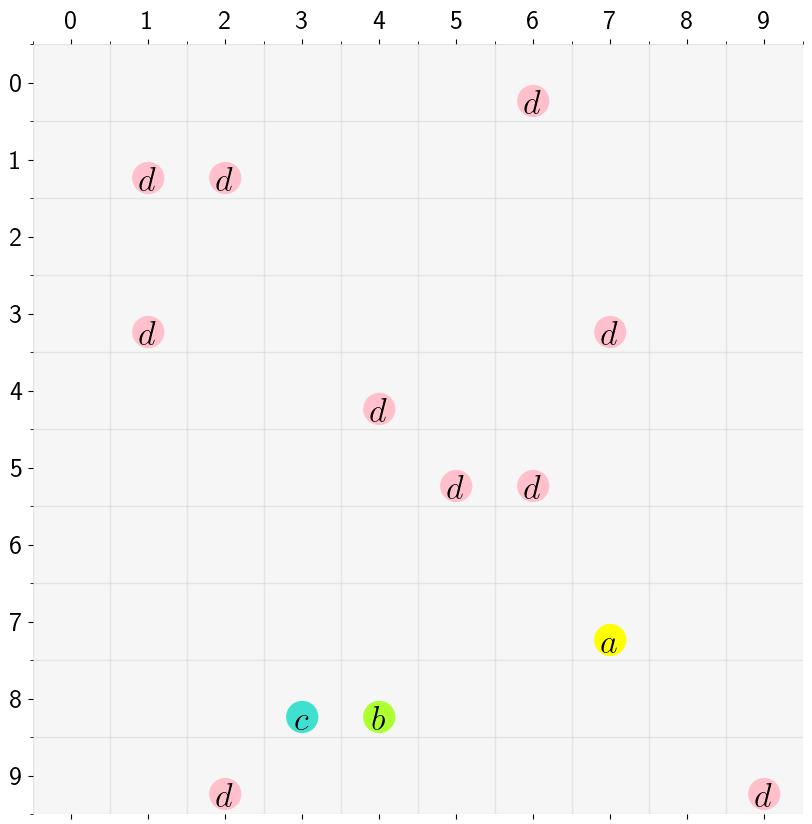

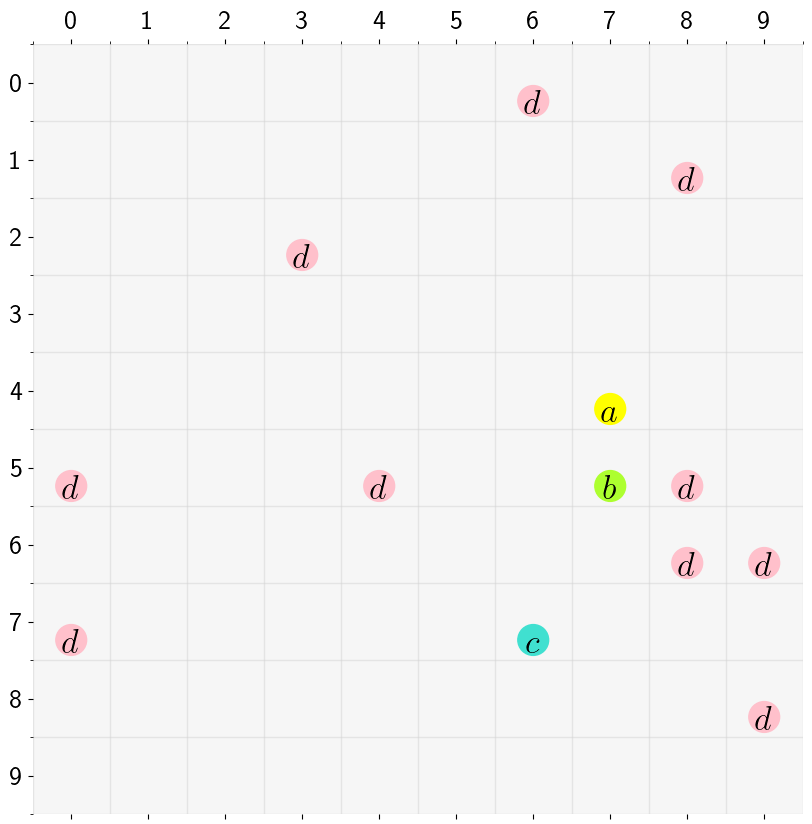

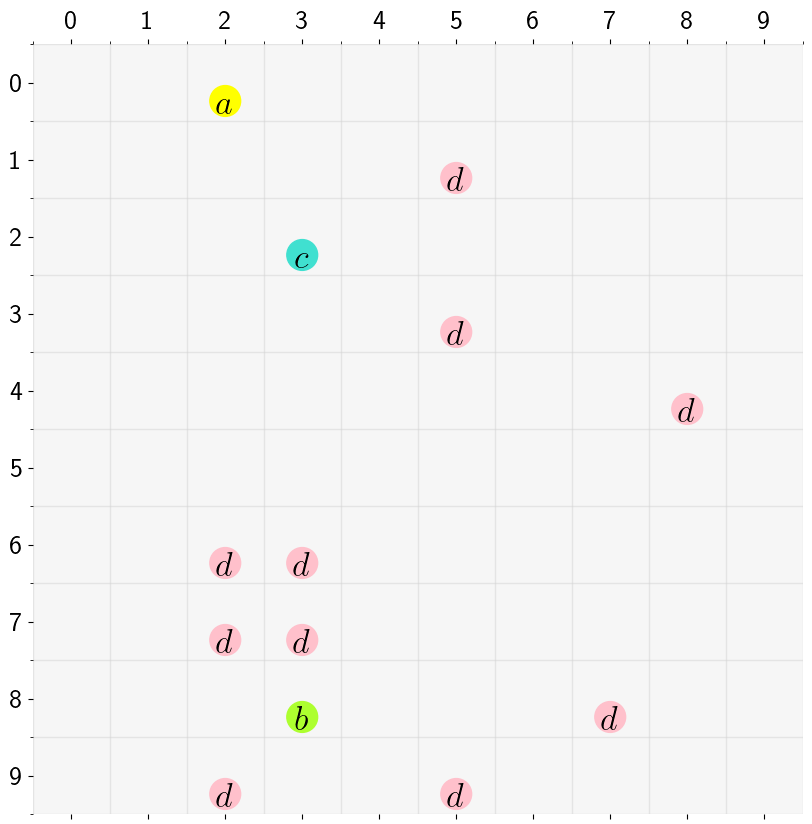

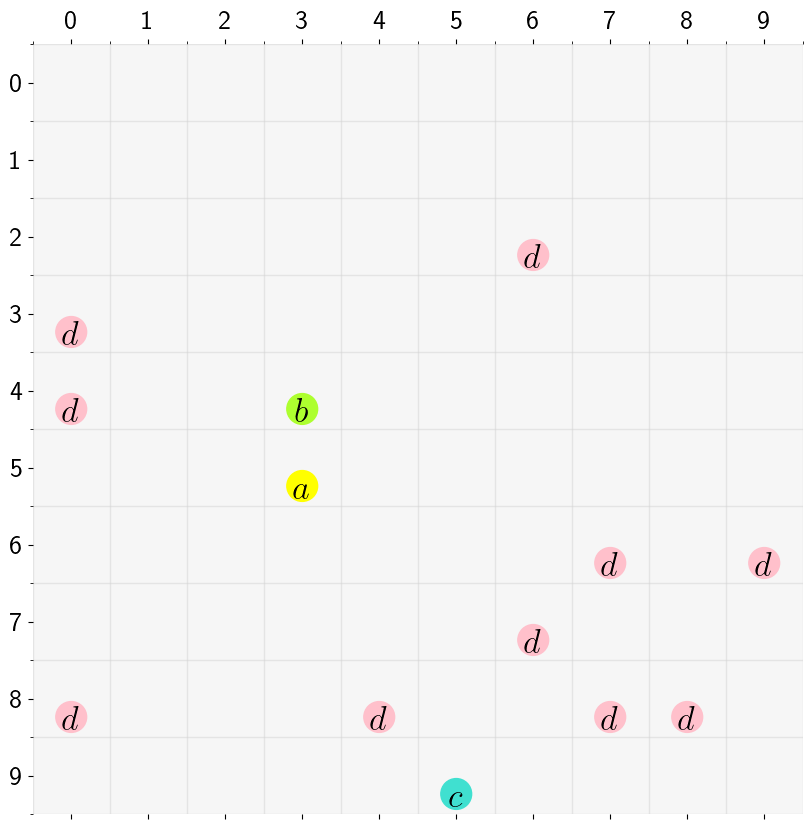

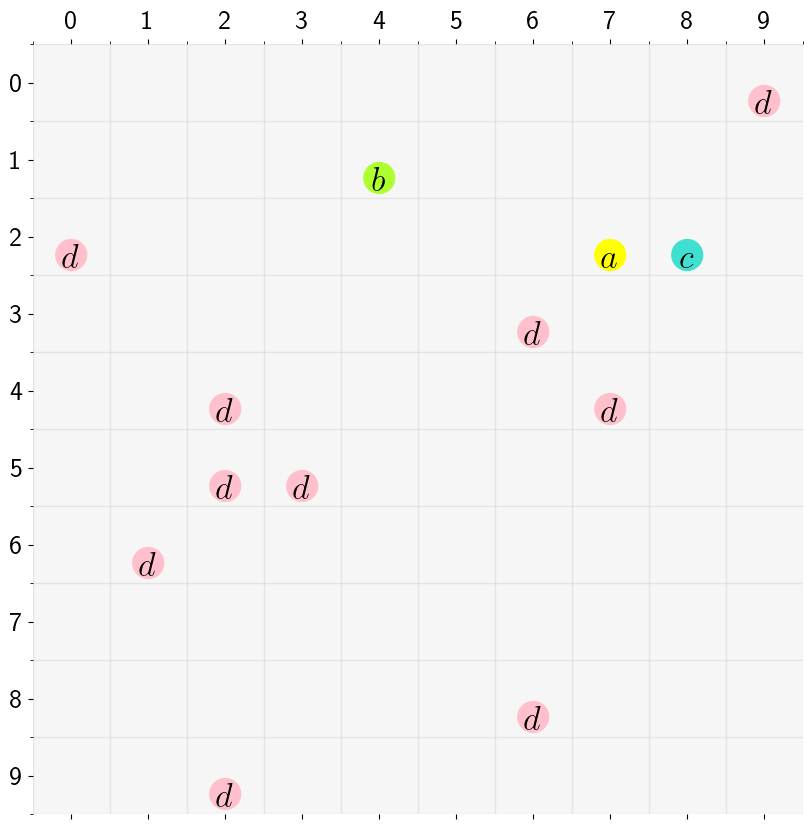

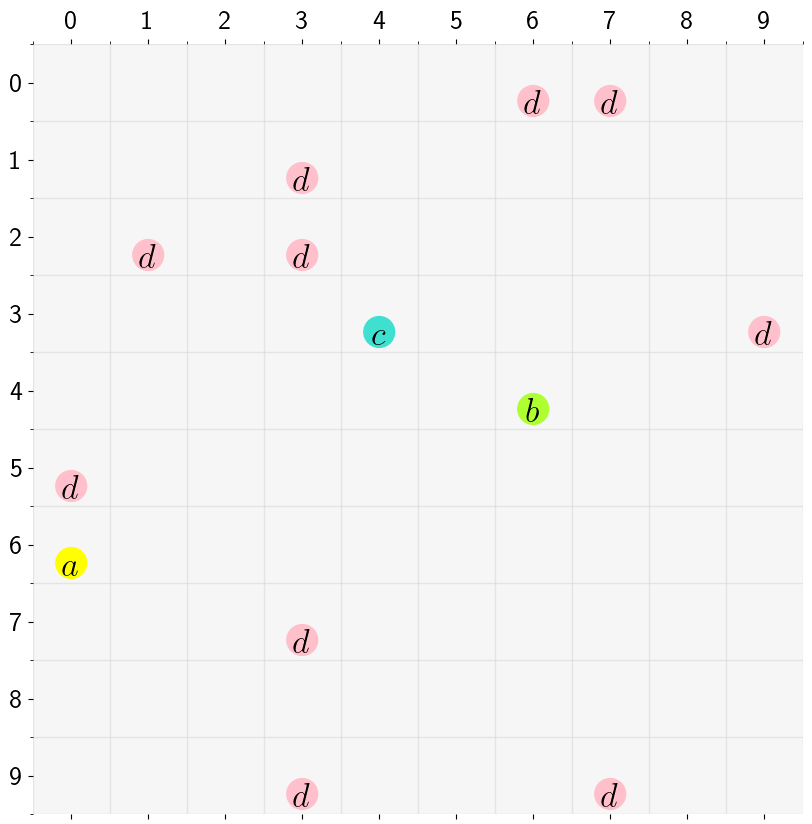

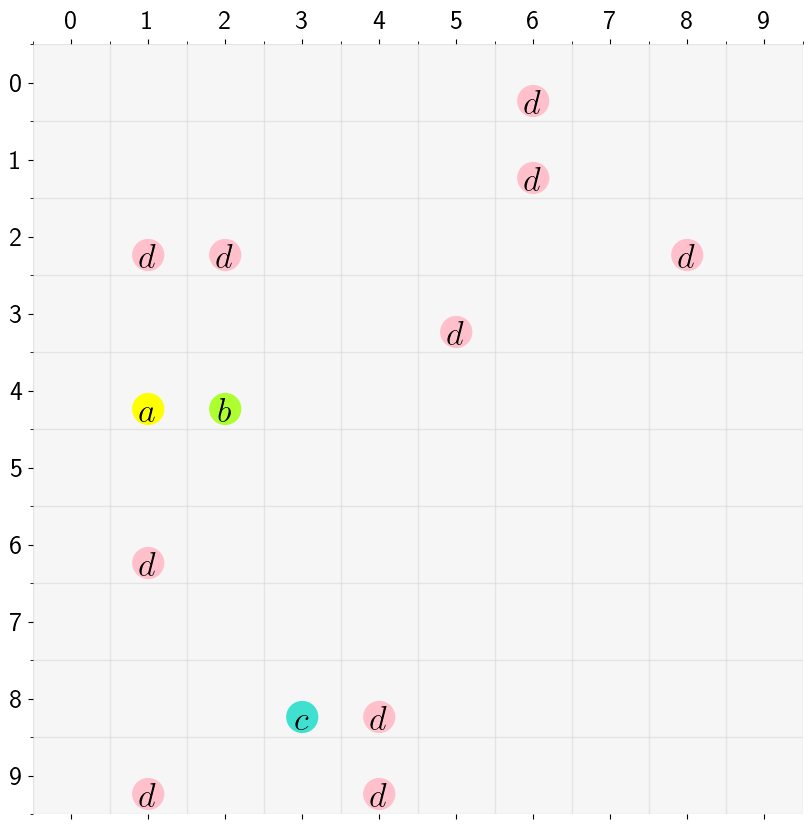

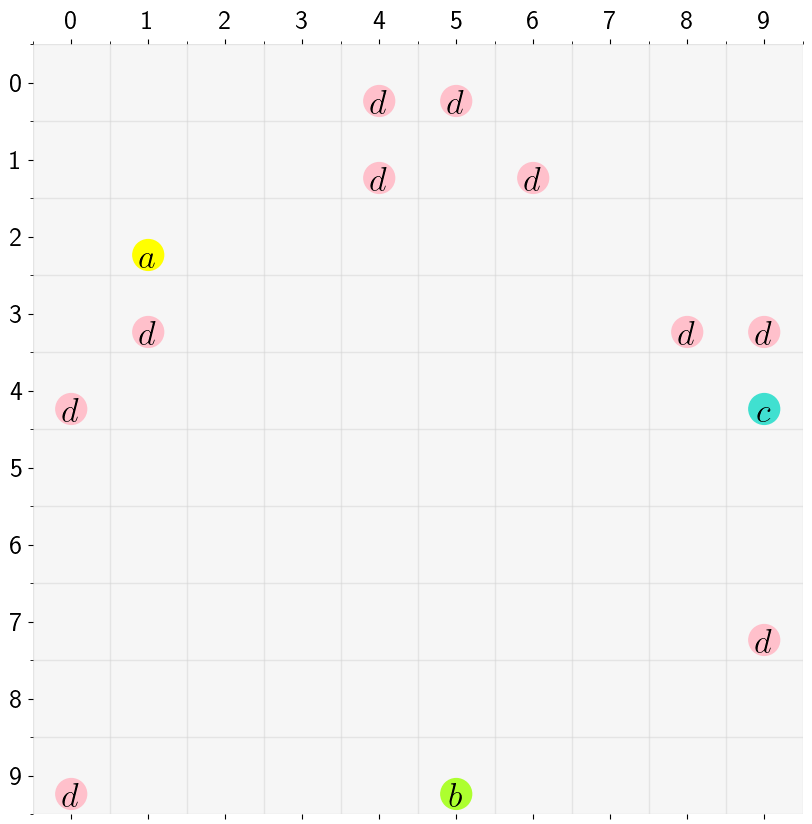

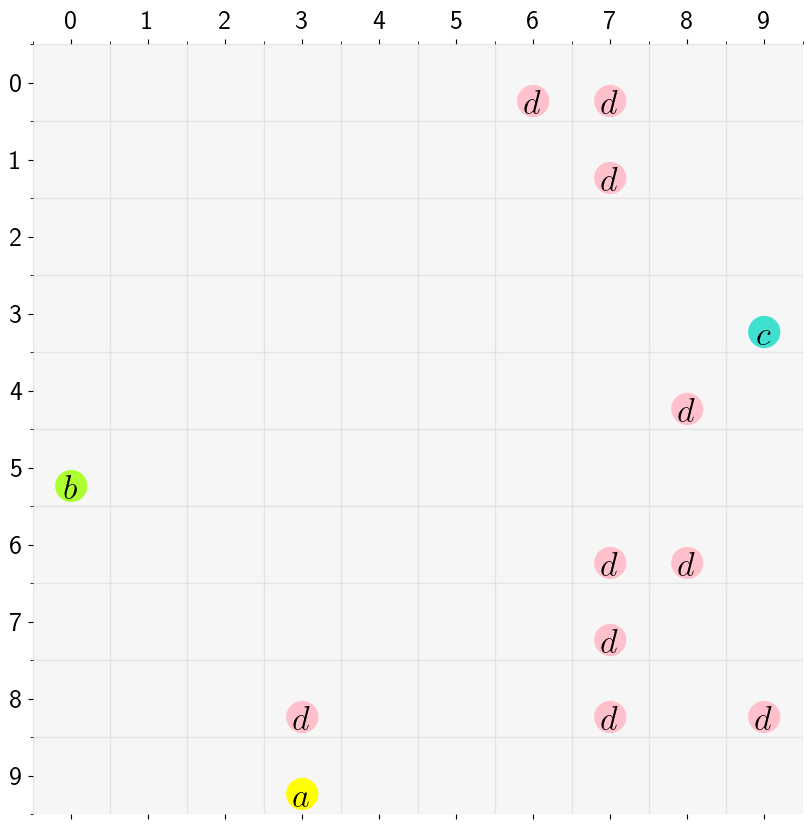

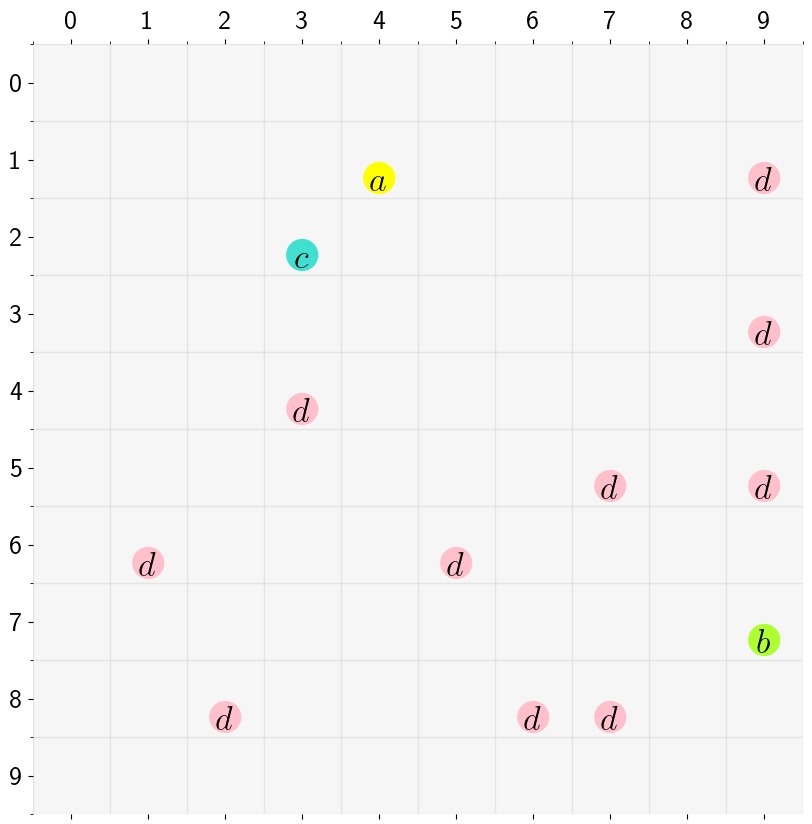

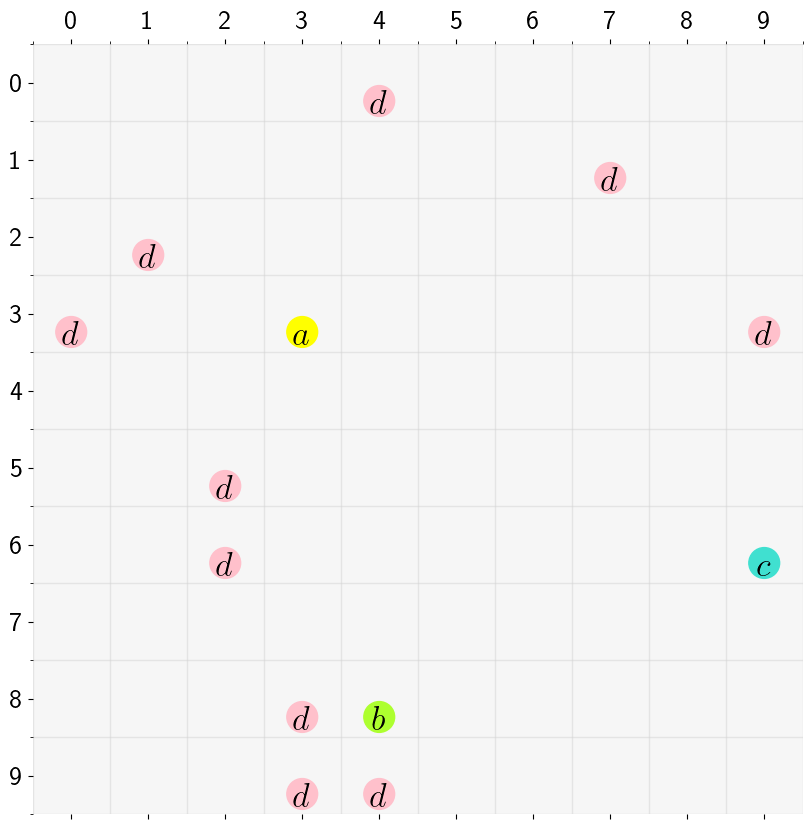

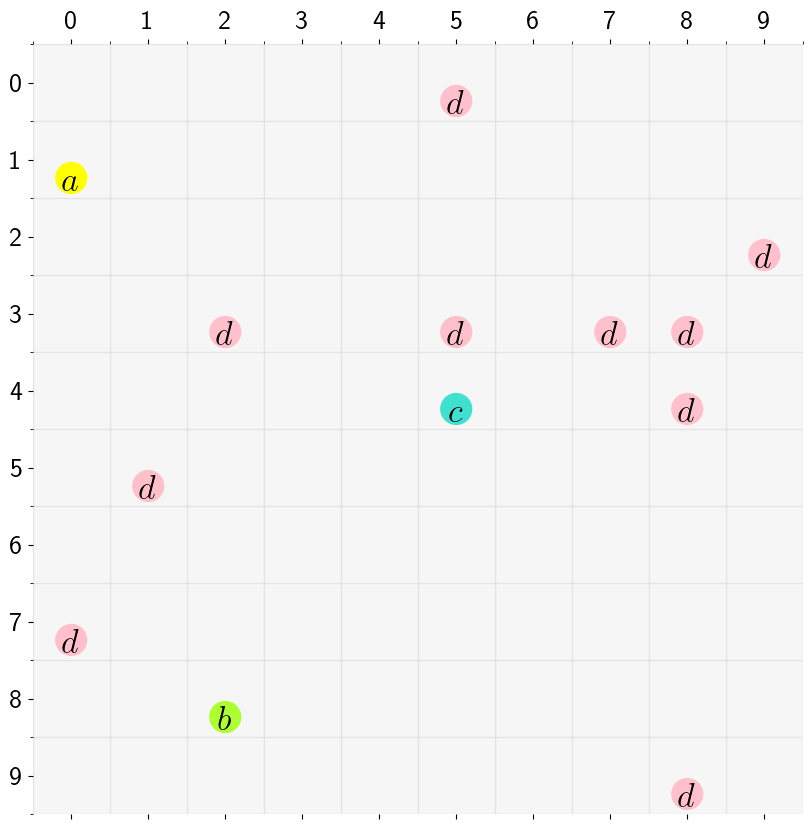

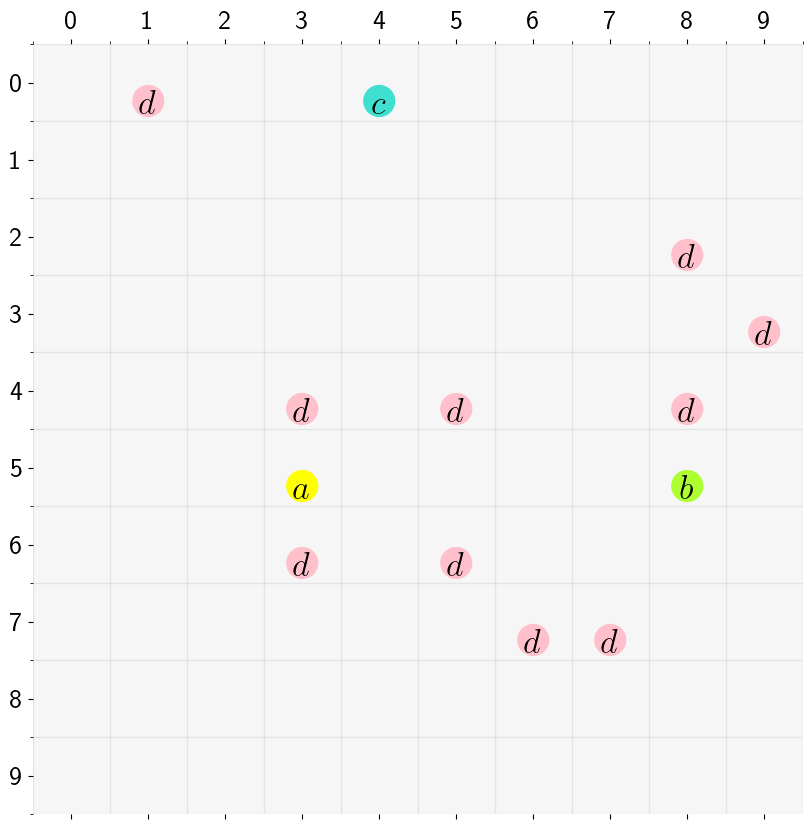

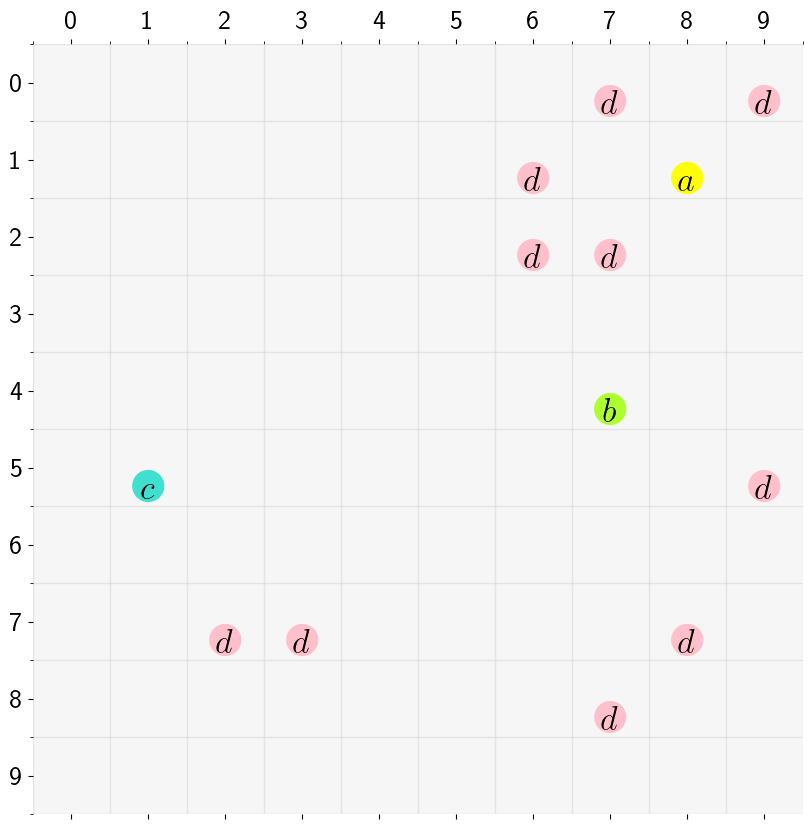

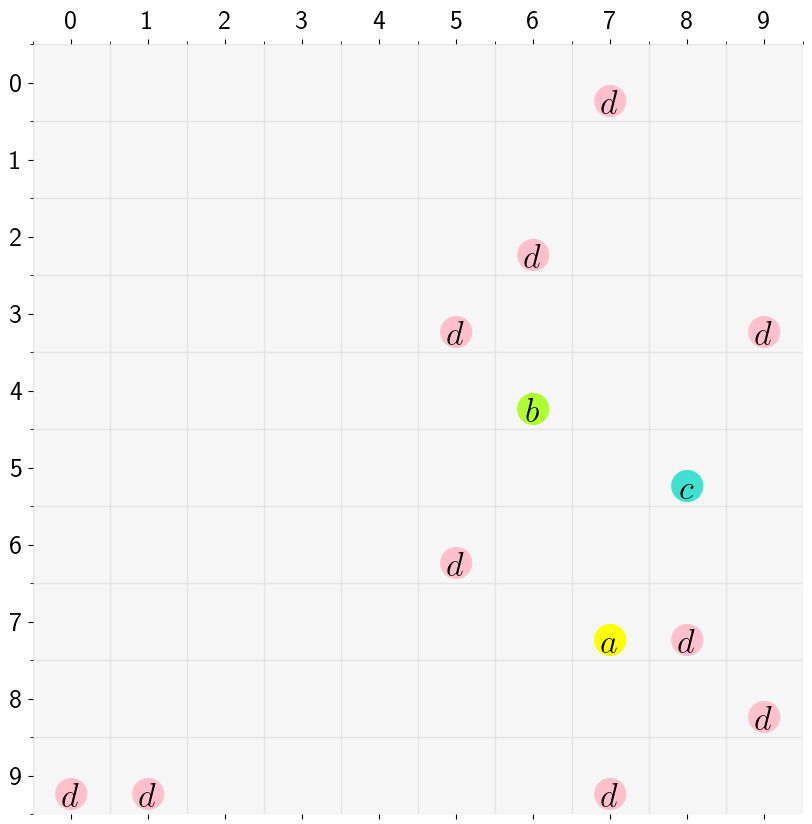

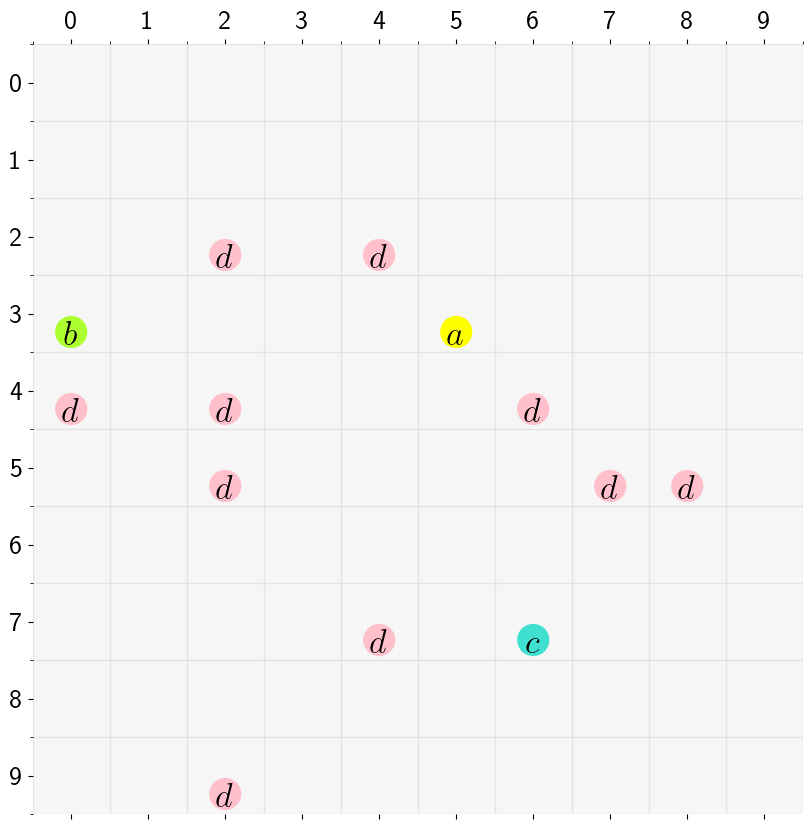

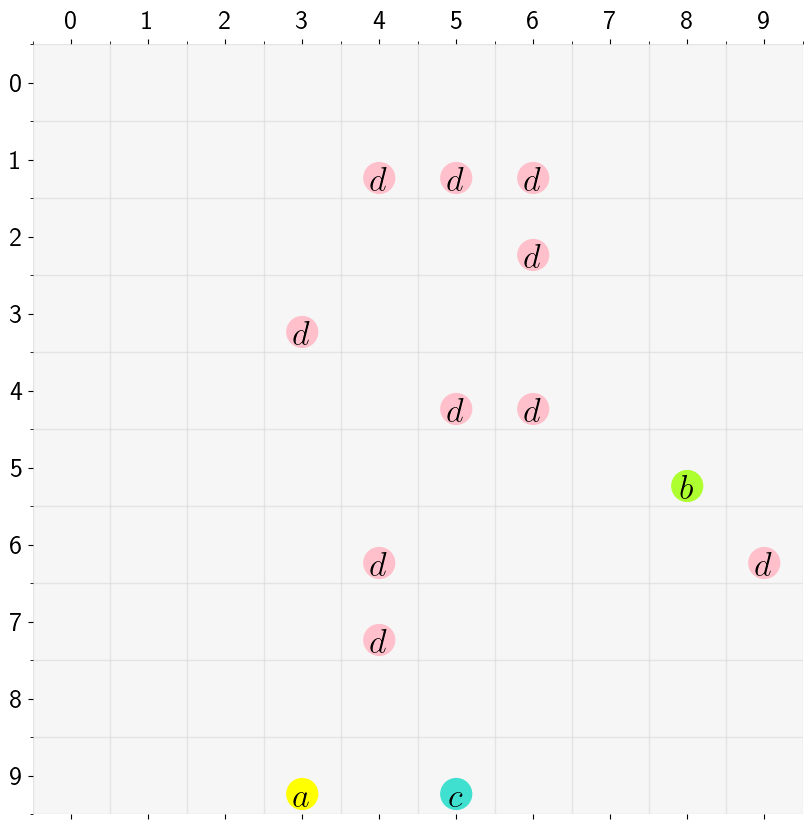

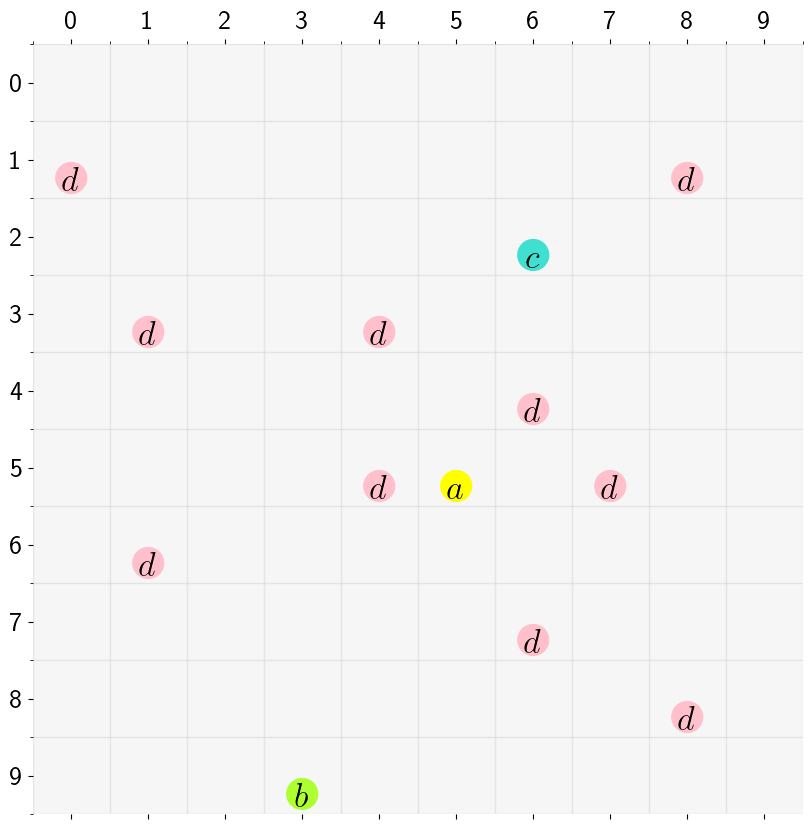

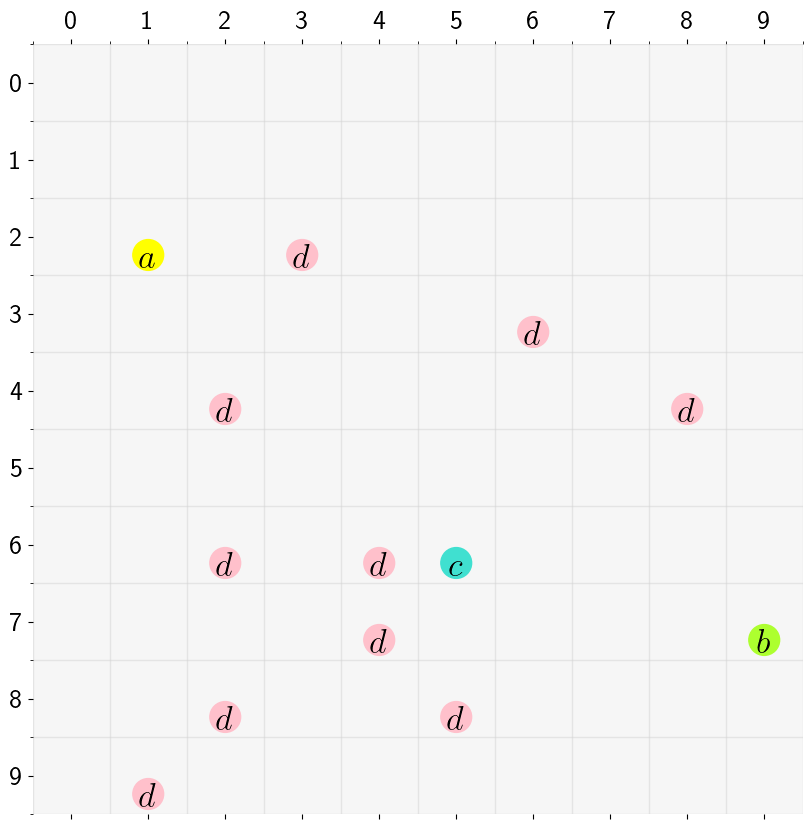

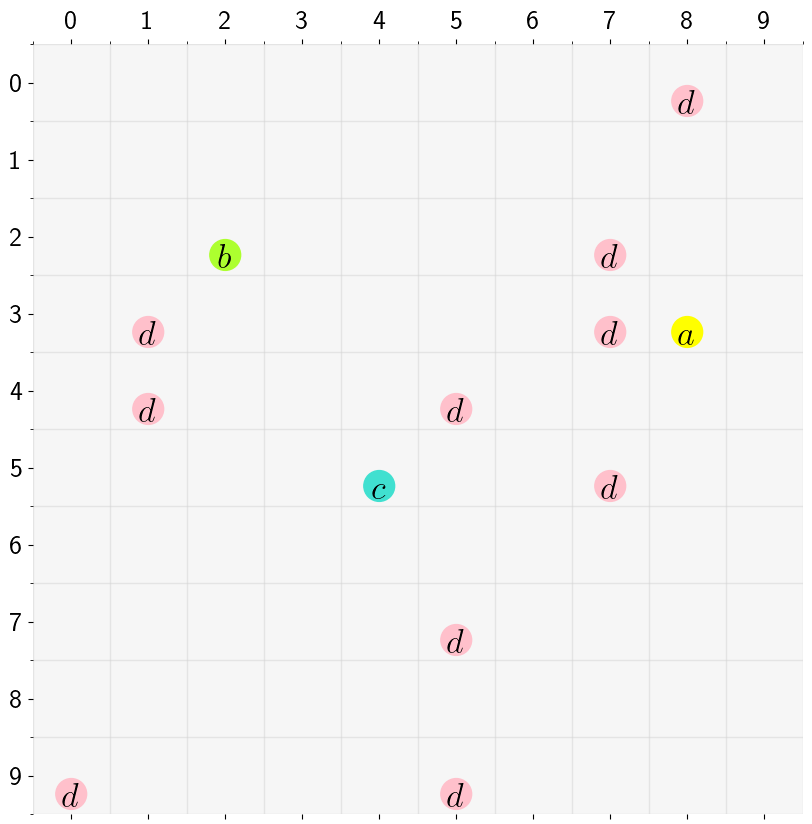

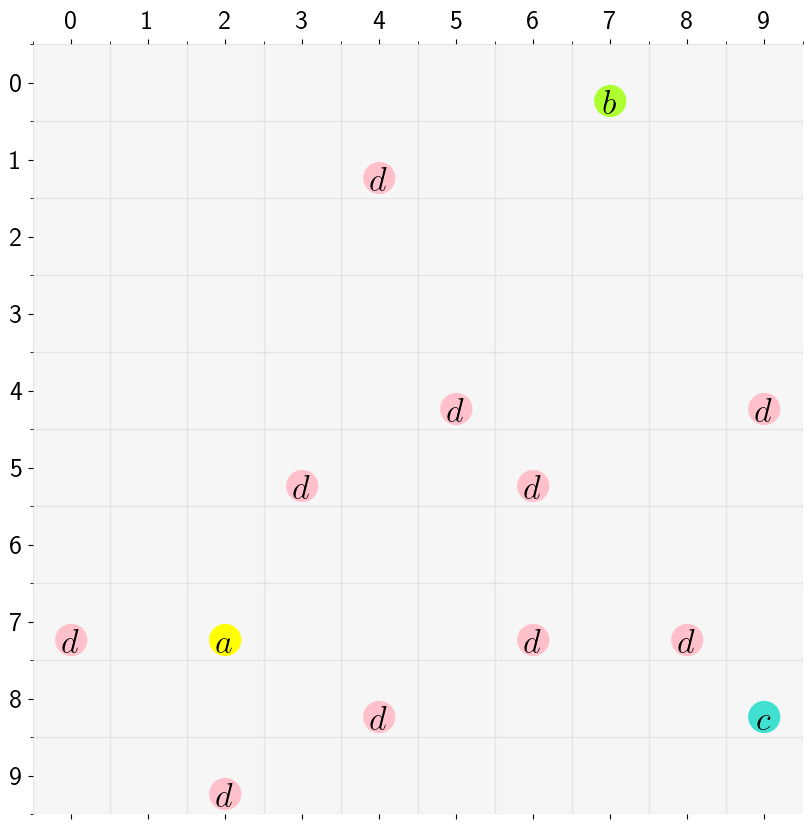

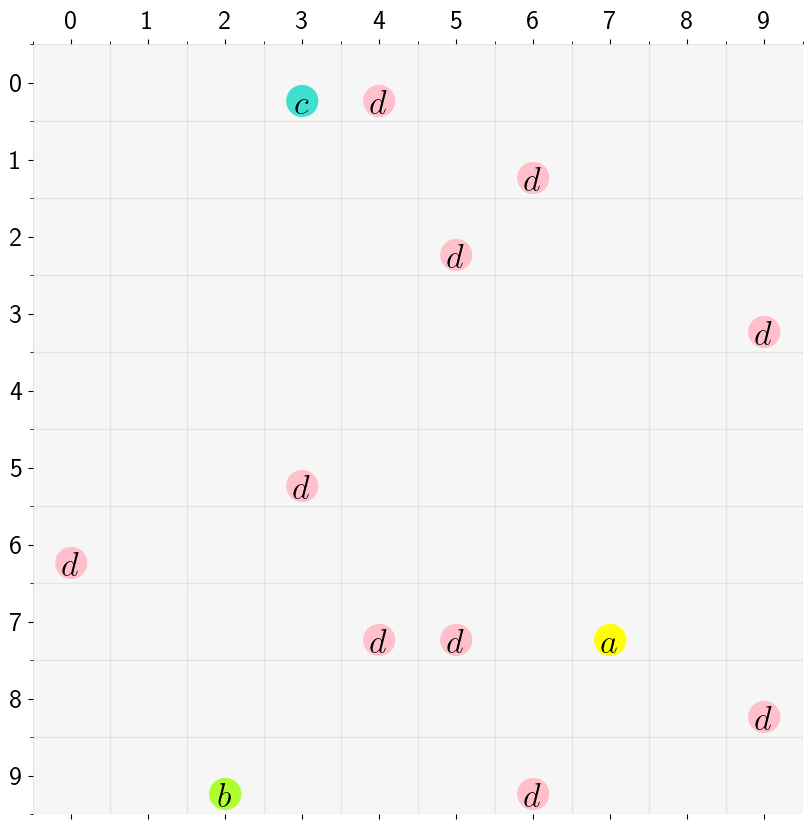

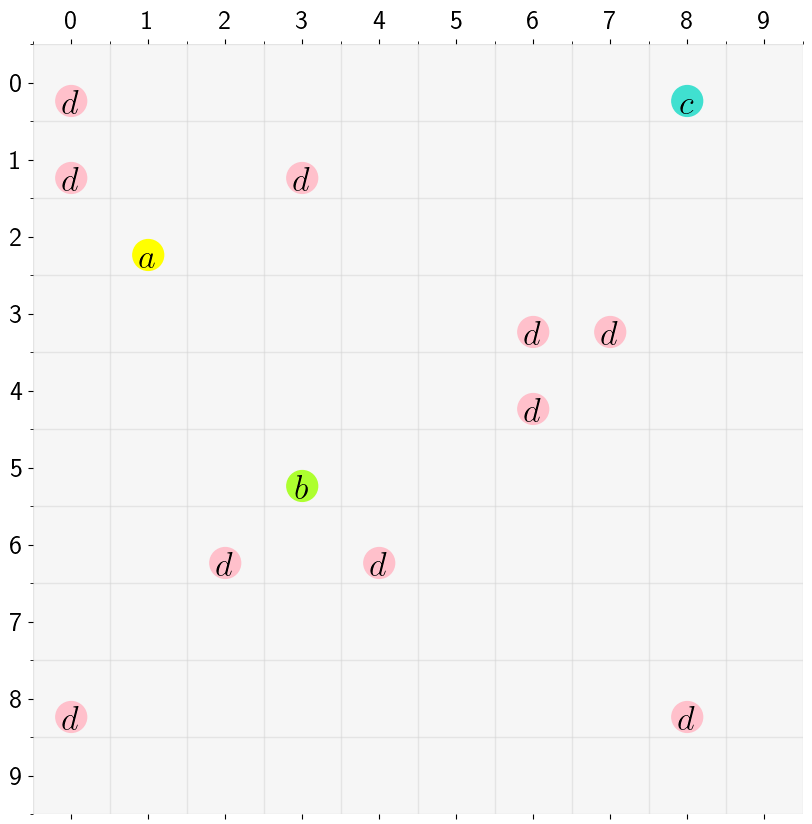

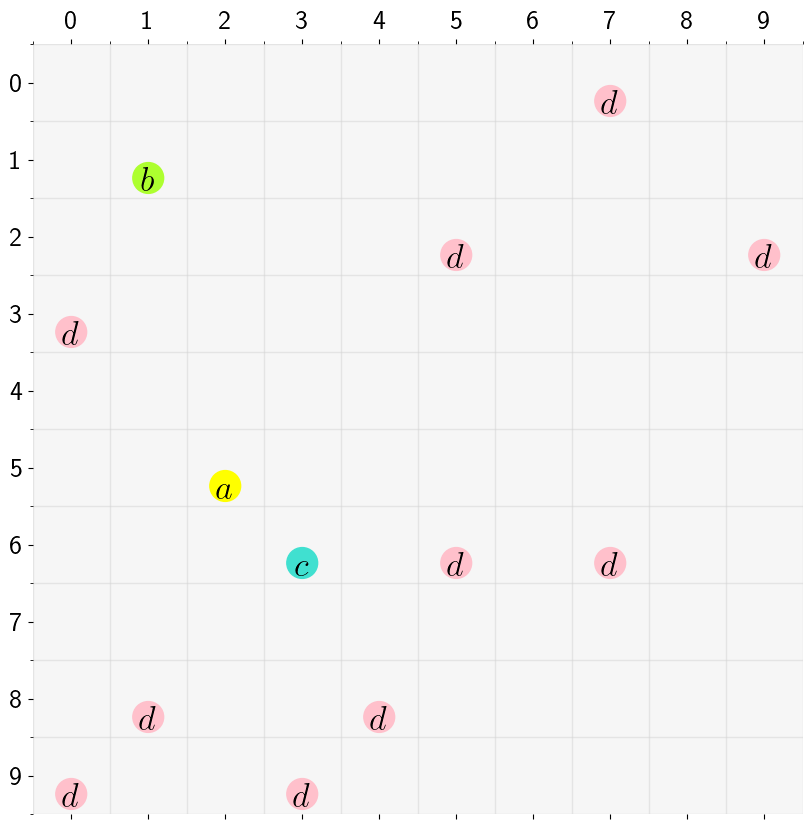

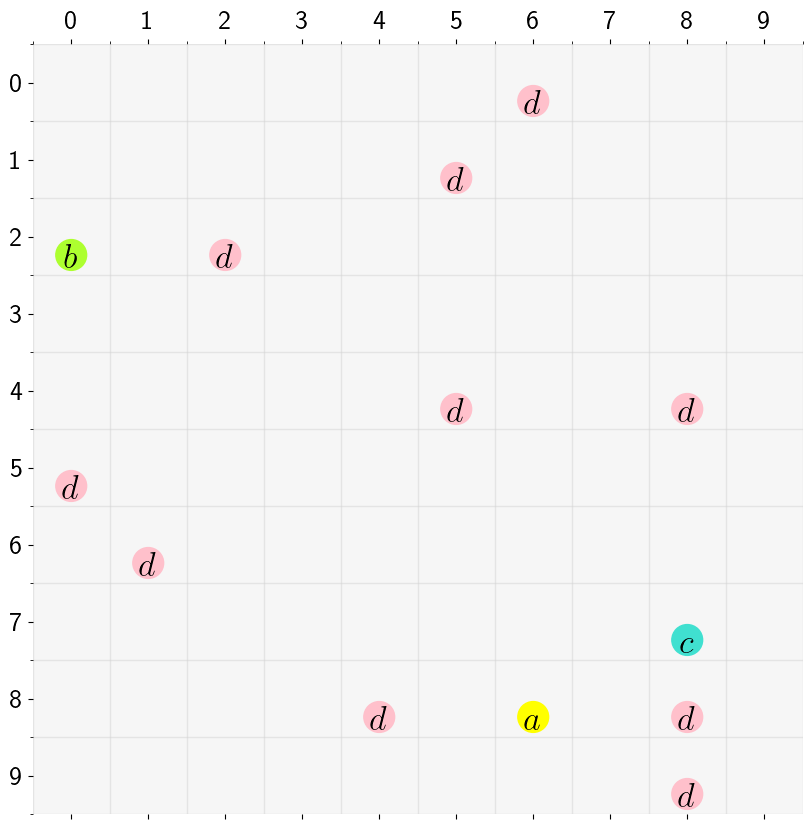

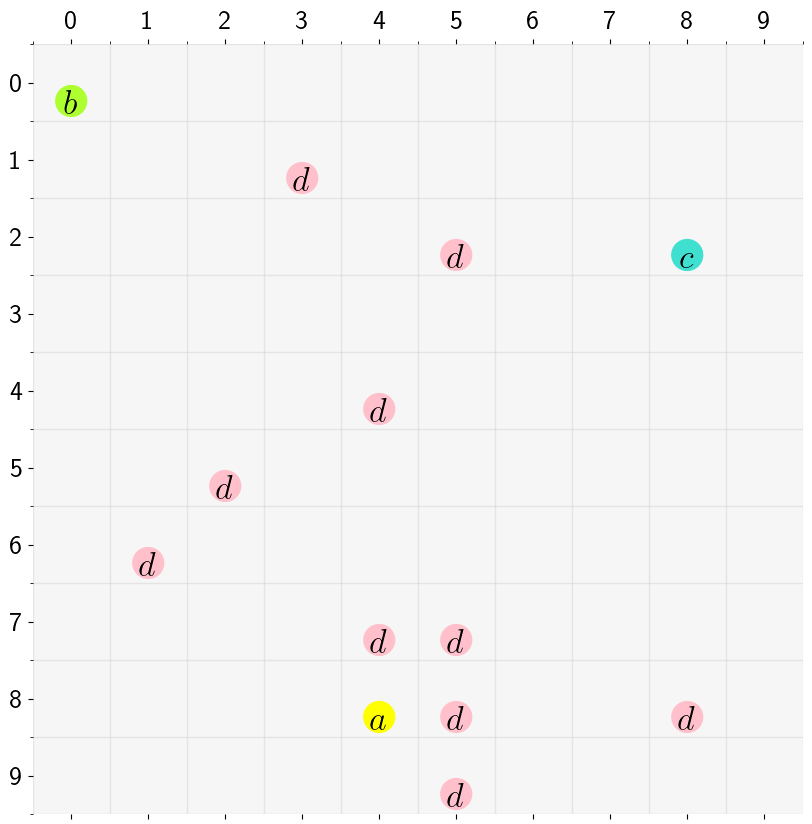

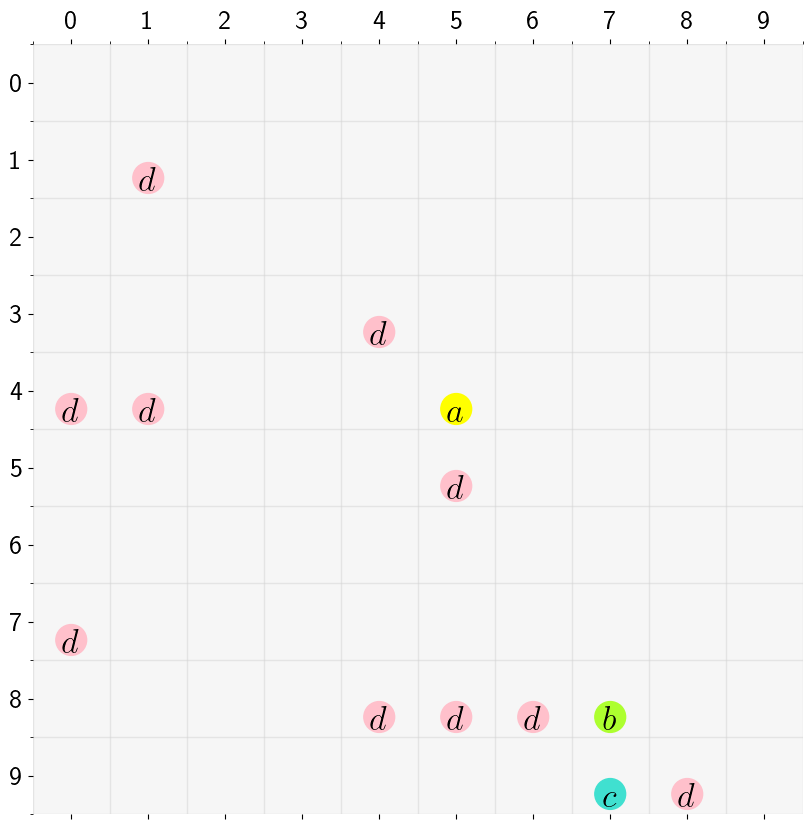

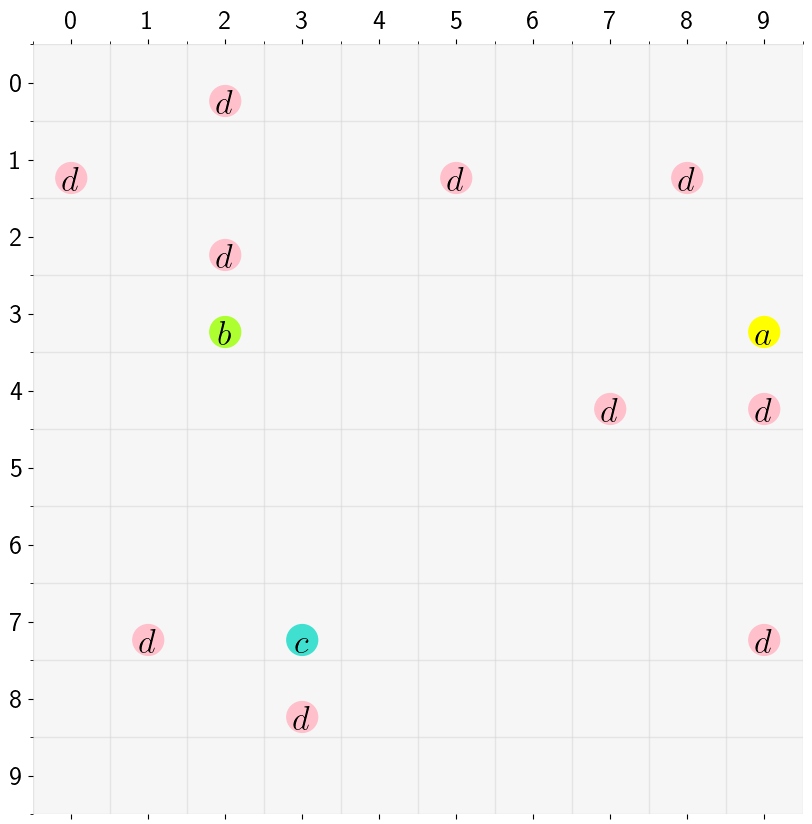

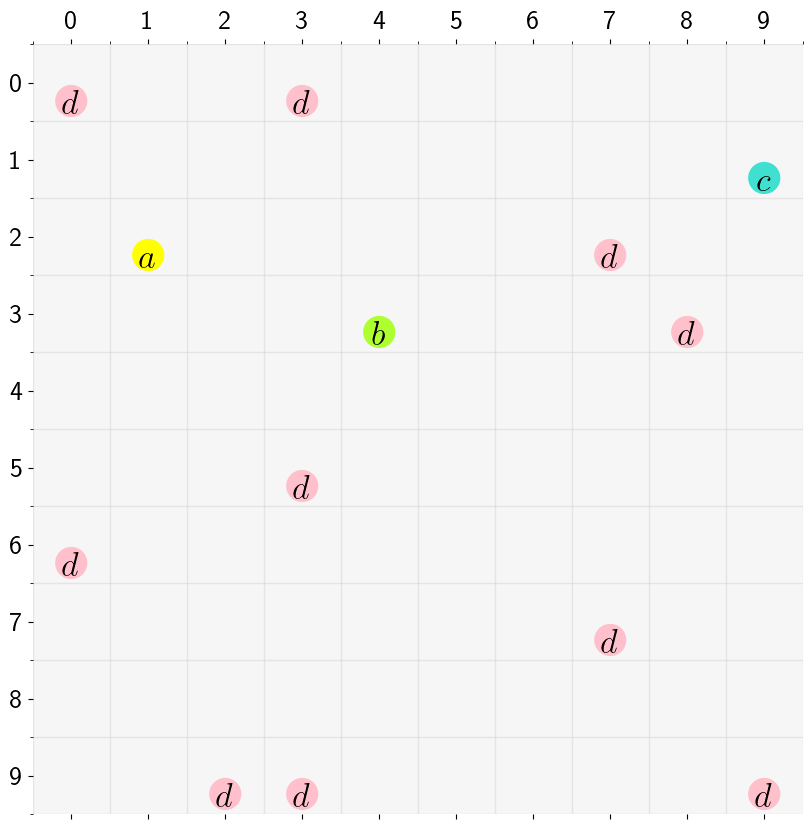

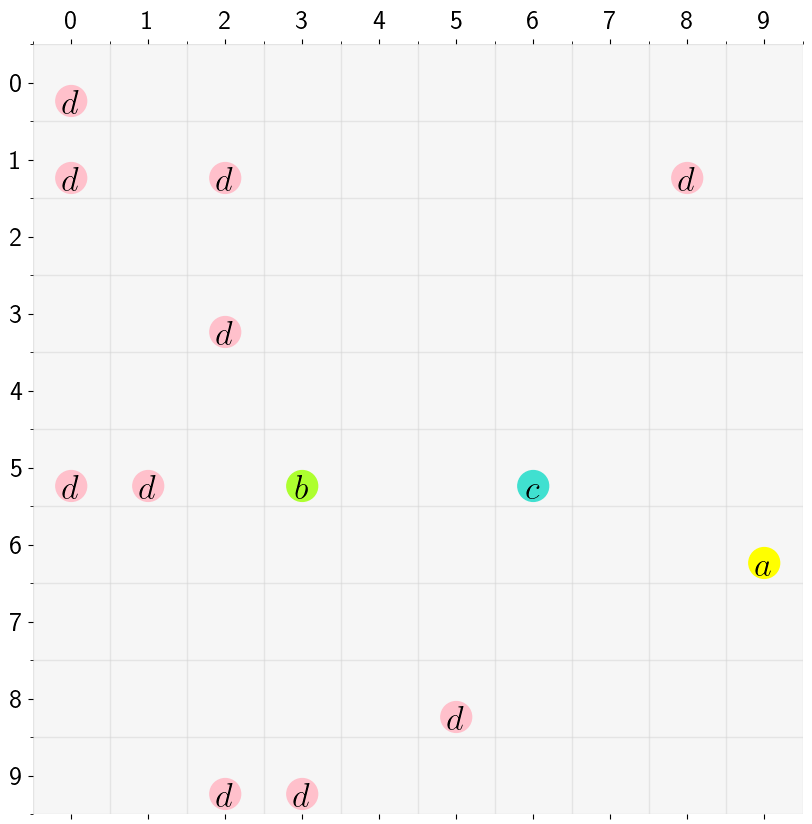

In [48]:
for i in range(30):
    gw = grid_world(name='random', plot=True, shape=(10,10), p=1)
    with open(f'outputs/gws/train/gw{i}.dat', 'wb') as f:
        pickle.dump(gw, f)

Number of Omega-automaton states (including the trap state): 6


2024-03-22 14:07:11.855052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 14:07:11.855938: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


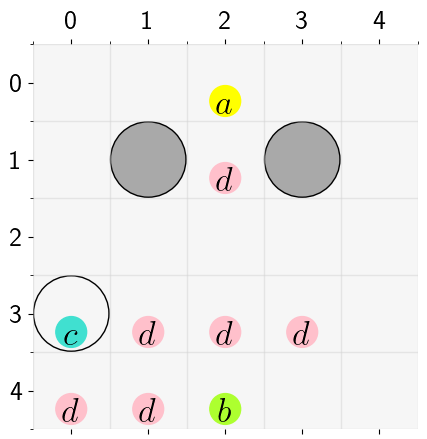

In [3]:
gw = grid_world(name='sequential_delivery', n_danger=6, plot=True, p=1)
csrl = gw.csrl
model = build_model(gw.ch_states[(0,0,0,0)].shape, gw.csrl.shape[-1])
model.load_weights(f'outputs/models/gen_mdp/sequential_delivery_p{gw.p}')

In [12]:
for n in range(1, 6):
    gw = grid_world(name='sequential_delivery', n_danger=n, plot=False, p=1, csrl=csrl)
    env = RL_LTL(gw, model)

    env.train(20, smart_start=True)
    env.get_policy(1, reset_tables=False)

    with open(f'outputs/Ours/gen_mdp/sequential_delivery_{n}_p{gw.p}.txt', 'w') as f:
        f.write('succ_rate:\n')
        f.write(', '.join(str(i) for i in env.policy_succ_rate))

    model.save_weights(f'outputs/models/gen_mdp/sequential_delivery_p{gw.p}')
    np.save(f'outputs/Ours/sequential_delivery_{n}_p{gw.p}', env.policy)

Number of Omega-automaton states (including the trap state): 6
##########################
C: 0.5 | tow: 0.2
0 ) MCTS conf: -0.09 , det: 0.98 | s: 5 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 202 / 500 = 0.404
1 ) MCTS conf: 0.97 , det: 1.0 | s: 19 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 411 / 500 = 0.822
2 ) MCTS conf: 0.98 , det: 0.97 | s: 13 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 436 / 500 = 0.872
3 ) MCTS conf: 0.95 , det: 0.97 | s: 11 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 432 / 500 = 0.864
4 ) MCTS conf: -0.49 , det: 0.83 | s: 21 LTL_f [---]  LDBA [ 0.0 ] observ

In [6]:
gw = grid_world(name='sequential_delivery', n_danger=6, plot=False, p=1)
model = build_model(gw.ch_states[(0,0,0,0)].shape, gw.csrl.shape[-1])
# model.load_weights(f'outputs/models/gen_mdp/sequential_delivery_p{gw.p}')
env = RL_LTL(gw, model)
env.train(num_training_epochs=10, smart_start=True)
env.get_policy(1, reset_tables=False)
env.policy_succ_rate

Number of Omega-automaton states (including the trap state): 6
##########################
C: 0.5 | tow: 0.2
0 ) MCTS conf: -0.23 , det: 0.92 | s: 23 LTL_f [---]  LDBA [ 0.0 ] observed labels: [('b',) ('a',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',)
 ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',)
 ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',) ('c',)
 ('c',)]
1 ) MCTS conf: -0.3 , det: 0.99 | s: 13 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('b',) ('a',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 245 / 500 = 0.49
2 ) MCTS conf: 0.95 , det: 0.93 | s: 3 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('b',) ('a',) ('c',)]
Running 500 simulations with 50 time-steps...
Test finished with:
	success rate: 281 / 500 = 0.562
3 ) MCTS conf: 0.93 , det: 0.99 | s: 9 LTL_f [+++]  LDBA [ 0.0 ] observed labels: [('a',) ('b',) ('b',) ('a',) ('c',)]
Running 500 simulations with 50

[0.49, 0.562, 0.698, 0.936, 1.0, 1.0]

[0.492, 0.544, 0.728, 0.85, 0.792, 0.79, 0.936, 0.926]

In [20]:
for name in ['mine_craft_'+str(j) for j in range(1,11)]:
    print(name)
    gw = grid_world(name=name, plot=False, p=0.8)
    Q =gw.csrl.q_learning(T=100,K=3000000)
    np.save(f'outputs/CSRL/{name}_p{gw.p}', Q)


mine_craft_1
Number of Omega-automaton states (including the trap state): 4
mine_craft_2
Number of Omega-automaton states (including the trap state): 4
mine_craft_3
Number of Omega-automaton states (including the trap state): 4
mine_craft_4
Number of Omega-automaton states (including the trap state): 4
mine_craft_5
Number of Omega-automaton states (including the trap state): 6
mine_craft_6
Number of Omega-automaton states (including the trap state): 6
mine_craft_7
Number of Omega-automaton states (including the trap state): 6
mine_craft_8
Number of Omega-automaton states (including the trap state): 6
mine_craft_9
Number of Omega-automaton states (including the trap state): 7
mine_craft_10
Number of Omega-automaton states (including the trap state): 7


In [13]:
name = 'mine_craft_10'
gw = grid_world(name=name, plot=False, p=1)
Q = np.load(f'outputs/CSRL/{name}_p{1}.npy')
policy2=np.argmax(Q,axis=4)
value2=np.max(Q,axis=4)
episodes, rew, rew_table = run_Q_test(gw.csrl, policy2, gw.LTL_formula, gw.predicates, start=None, T=28, runs=500, verbose=0, reachability=True)

Number of Omega-automaton states (including the trap state): 7
Running 500 simulations with 28 time-steps...
Test finished with:
	success rate: 483 / 500 = 0.966


In [22]:
all_rates = []
for name in ['mine_craft_'+str(j) for j in range(1,11)]:
    print(name)
    tmp = []
    for t in range(10,41, 5):
        gw = grid_world(name=name, plot=False, p=0.8)
        Q = np.load(f'outputs/CSRL/{name}_p{gw.p}.npy')
        policy2=np.argmax(Q,axis=4)
        value2=np.max(Q,axis=4)
        episodes, rew, rew_table = run_Q_test(gw.csrl, policy2, gw.LTL_formula, gw.predicates, start=None, T=t, runs=1000, verbose=0, reachability=True)
        tmp.append(100*np.sum(rew)/len(rew))
    all_rates.append(tmp)
np.array(all_rates).mean(0)

mine_craft_1
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 10 time-steps...
Test finished with:
	success rate: 535 / 1000 = 0.535
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 15 time-steps...
Test finished with:
	success rate: 911 / 1000 = 0.911
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 20 time-steps...
Test finished with:
	success rate: 994 / 1000 = 0.994
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 25 time-steps...
Test finished with:
	success rate: 999 / 1000 = 0.999
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 30 time-steps...
Test finished with:
	success rate: 1000 / 1000 = 1.0
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 35 time-steps...
Test finished with:
	success rate: 1000 / 1000 = 1.0
Numbe

array([17.72, 38.99, 57.9 , 73.52, 83.73, 88.1 , 89.66])

In [23]:
for i in all_rates:
    print(i)

[53.5, 91.1, 99.4, 99.9, 100.0, 100.0, 100.0]
[53.8, 92.6, 99.3, 99.9, 100.0, 100.0, 100.0]
[14.2, 72.1, 95.5, 99.0, 100.0, 100.0, 100.0]
[54.9, 90.7, 99.6, 99.9, 100.0, 100.0, 100.0]
[0.0, 17.1, 63.4, 91.3, 98.9, 99.8, 99.9]
[0.0, 5.8, 45.9, 82.2, 96.7, 99.4, 100.0]
[0.0, 0.0, 14.3, 57.2, 89.1, 97.5, 99.9]
[0.8, 20.5, 61.2, 90.0, 97.8, 99.4, 99.9]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.4, 15.8, 54.8, 84.9, 96.9]


In [49]:
np.array(all_rates).mean(0)

array([18.1, 38.2, 57.1, 74.3, 83.4, 88.1, 89.5, 89.8, 90. ])

In [26]:
all_rates

[[33.0, 67.1, 88.5, 93.6, 97.9, 98.4, 99.0],
 [14.7, 48.7, 82.2, 94.5, 98.8, 98.9, 99.4],
 [10.6, 46.1, 79.6, 94.0, 97.9, 99.2, 98.4],
 [29.1, 67.6, 90.8, 97.6, 98.6, 99.3, 99.6],
 [0.0, 6.9, 36.7, 77.0, 92.1, 97.6, 99.2],
 [0.0, 0.7, 13.2, 43.6, 68.0, 86.6, 95.8],
 [0.0, 0.0, 5.2, 22.9, 53.2, 74.3, 89.7],
 [0.0, 0.2, 0.8, 3.6, 17.1, 48.4, 73.9],
 [0.0, 0.0, 0.0, 2.3, 14.7, 44.0, 70.9],
 [0.0, 0.0, 0.0, 3.1, 14.3, 41.0, 63.8]]

In [25]:
all_rates = []
for name in ['mine_craft_'+str(j) for j in range(1,11)]:
    print(name)
    tmp = []
    for t in range(10,41, 5):
        gw = grid_world(name=name, plot=False, p=0.8)
        policy = np.load(f'outputs/Ours/{name}_p{gw.p}.npy')
        episodes, rew, rew_table = run_Q_test(gw.csrl, policy, gw.LTL_formula, gw.predicates, start=None, T=t, runs=1000, verbose=0, reachability=True)
        tmp.append(100*np.sum(rew)/len(rew))
    all_rates.append(tmp)
np.array(all_rates).mean(0)

mine_craft_1


Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 10 time-steps...
Test finished with:
	success rate: 330 / 1000 = 0.33
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 15 time-steps...
Test finished with:
	success rate: 671 / 1000 = 0.671
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 20 time-steps...
Test finished with:
	success rate: 885 / 1000 = 0.885
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 25 time-steps...
Test finished with:
	success rate: 936 / 1000 = 0.936
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 30 time-steps...
Test finished with:
	success rate: 979 / 1000 = 0.979
Number of Omega-automaton states (including the trap state): 4
Running 1000 simulations with 35 time-steps...
Test finished with:
	success rate: 984 / 1000 = 0.984
Number of Omega-a

array([ 8.74, 23.73, 39.7 , 53.22, 65.26, 78.77, 88.97])

In [31]:
# running the sequential delivery case for 3 danger zones with 3 million iterations and p=0.8
gw = grid_world(name='sequential_delivery', n_danger=3, plot=False, p=0.8)
Q =gw.csrl.q_learning(T=100,K=3000000)
np.save(f'outputs/CSRL/sequential_delivery_3_p{gw.p}', Q)

policy2=np.argmax(Q,axis=4)
value2=np.max(Q,axis=4)
episodes, rew, rew_table = run_Q_test(gw.csrl, policy2, gw.LTL_formula, gw.predicates, start=None, T=100, runs=100, verbose=0, reachability=True)

Number of Omega-automaton states (including the trap state): 6
Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 99 / 100 = 0.99


In [39]:
episodes, rew, rew_table = run_Q_test(gw.csrl, policy2, gw.LTL_formula, gw.predicates, start=None, T=50, runs=1000, verbose=0, reachability=True)

Running 1000 simulations with 50 time-steps...


Test finished with:
	success rate: 982 / 1000 = 0.982


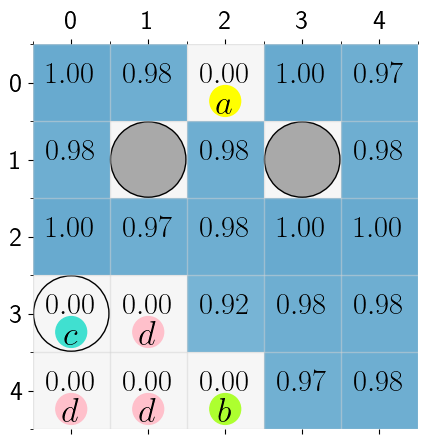

In [40]:
gw.mdp.plot(value=rew_table)

In [17]:
Q = np.load(f'outputs/CSRL/mine_craft_9_p{gw.p}.npy')

Number of Omega-automaton states (including the trap state): 4


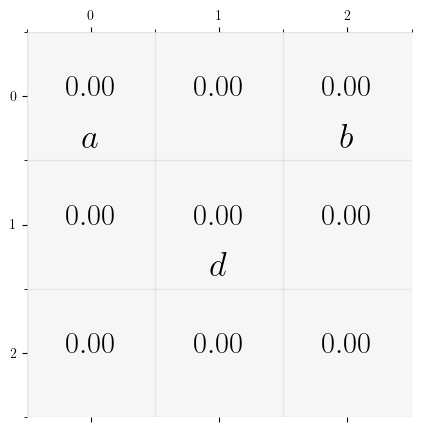

In [3]:
# LTL Specification
ltl = '(F G a | F G b) & G !d'

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])
display(oa)

# MDP Description
shape = (3,3)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E'],
['E',  'E',  'E'],
['E',  'E',  'E'],
])

# Labels of the states
label = np.array([
[('a',),(),('b',)],
[(),('d',),    ()],
[(),    (),    ()],
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'lightgreen',
    ('b',):'lightgreen',
    ('d',):'pink'
}
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)

In [4]:
full_t = "(<> [] a \/ <> [] b) /\ [] ~d"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)
predicates

{'a': [0], 'b': [2], 'd': [4]}

In [5]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
# model.summary()

In [6]:
LTL_coef = 10
NN_value_active = False
search_depth = 100
MCTS_samples = 100
training = True
epochs = 15
C = 1
tow = 0.1
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []
best_val_len = {}
for s in csrl.states(): best_val_len[s] = (0.001, 99999)

num_training_epochs =  10
# os.remove("outputs/Log_run.txt")
for i in T:
    idx += 1
    train_wins = 0
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False, reachability=True, 
                best_val_len = best_val_len)
        
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
    print("Train wins:",train_wins,"/", num_training_epochs)

# u, d, r, l

0 ) MCTS conf: -0.36 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [5, 5, 8, 7, 6, 3, 0, 0, 0, 3, 4]
1 ) MCTS conf: -0.39 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 7, 6, 3, 0, 0]
2 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [6, 3, 0, 0]
3 ) MCTS conf: 0.58 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 7, 6, 3, 0, 0]
4 ) MCTS conf: 0.96 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [1, 0, 0]
5 ) MCTS conf: 0.97 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 7, 6, 3, 0, 0]


KeyboardInterrupt: 

In [16]:
Policy = np.zeros(csrl.shape)
for i in csrl.states():
    x = (N[i]**(1/tow)) / np.sum(N[i]**(1/tow))
    Policy[i] = np.nan_to_num(x)

input_gws.append(channeled(csrl, enc, agent=False)[0,0,0,0].sum(0))
policies.append(Policy[0,:,:,:])

/tmp/ipykernel_110381/263196528.py:3: RuntimeWarning: invalid value encountered in divide
  x = (N[i]**(1/tow)) / np.sum(N[i]**(1/tow))


In [18]:
x = np.array(input_gws)
y = np.array(policies)

In [94]:
policy_model.fit(x, y, epochs = 1000)

Epoch 1/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3965 - accuracy: 0.7639
Epoch 2/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.3962 - accuracy: 0.7639
Epoch 3/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.3960 - accuracy: 0.7639
Epoch 4/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.3958 - accuracy: 0.7685
Epoch 5/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.3956 - accuracy: 0.7685
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.3954 - accuracy: 0.7731
Epoch 7/1000
1/1 [==============================] - 0s 68ms/step - loss: 0.3952 - accuracy: 0.7778
Epoch 8/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.3950 - accuracy: 0.7778
Epoch 9/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.3948 - accuracy: 0.7731
Epoch 10/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.3946 - accuracy: 0.7731
Epoch 11/

KeyboardInterrupt: 

In [136]:
pred_policy = policy_model(channeled(csrl, enc, agent=False)[0,0,0,0].sum(0).reshape(1,3,3))
# pred_policy = policy_model(input_gws[4].reshape(1,3,3))

pred_policy = np.argmax(pred_policy[0,0], 2)
pred_policy = np.where(pred_policy == 0, '^', pred_policy)
pred_policy = np.where(pred_policy == '1', 'v', pred_policy)
pred_policy = np.where(pred_policy == '2', '>', pred_policy)
pred_policy = np.where(pred_policy == '3', '<', pred_policy)

In [137]:
channeled(csrl, enc, agent=False)[0,0,0,0].sum(0).reshape(1,3,3)

array([[[2., 0., 3.],
        [0., 4., 0.],
        [0., 0., 0.]]])

In [138]:
pred_policy

array([['5', '>', '6'],
       ['>', '^', '^'],
       ['^', '^', '<']], dtype='<U21')

In [126]:
input_gws

[array([[2., 0., 3.],
        [0., 0., 0.],
        [0., 4., 0.]]),
 array([[2., 0., 3.],
        [0., 0., 0.],
        [4., 0., 0.]]),
 array([[2., 0., 3.],
        [4., 0., 0.],
        [0., 0., 0.]]),
 array([[2., 0., 3.],
        [0., 0., 4.],
        [0., 0., 0.]]),
 array([[2., 4., 3.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 array([[2., 0., 3.],
        [0., 0., 0.],
        [0., 0., 4.]])]

In [9]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10
NN_value_active = False

search_depth = 100
MCTS_samples = 100

num_training_epochs =  10
num_test_epochs = 10
training = True
epochs = 10
C = 1
tow = 0.1
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []

best_val_len = {}
for s in csrl.states(): best_val_len[s] = (0.001, 99999)

# os.remove("Log_run.txt")
for i in T:
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=C, tow=tow, n_samples=MCTS_samples, visited=visited_train,
                start=None, search_depth=search_depth, verbose=0, T=i, K=K, NN_value_active=NN_value_active, run_num=epoch, ltl_f_rew=False, reachability=True, 
                best_val_len = best_val_len)
        # print("!", best_val_len[(0,0,0,0)])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0:
            train_wins+=1
            NN_value_active = True

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy, best_val_len = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=None, search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True, reachability=True, best_val_len = best_val_len)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

? 0.6
0 ) MCTS conf: 0.17 , det: 1.0 | ? 1
LTL [+++]  LDBA [ 0.01 ] path: [3, 0, 0]
? 0.05260303
? 1
1 ) MCTS conf: 0.96 , det: 1.0 | ? 1
LTL [+++]  LDBA [ 0.01 ] path: [5, 2, 2]
? 0.06288229
? 0.9939205570480697
? 1
2 ) MCTS conf: 0.99 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [6, 3, 0, 0]
? 0.0014226277
? 1
3 ) MCTS conf: 0.99 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [8, 5, 2, 2]
? 0.34072602
? 0.37543768
? 0.3911557
? 1
4 ) MCTS conf: 0.22 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [7, 6, 3, 0, 0]
5 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 2, 2]
6 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [7, 6, 3, 0, 0]
7 ) MCTS conf: 0.99 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [7, 6, 3, 0, 0]
8 ) MCTS conf: 0.19 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [3, 0, 0]
9 ) MCTS conf: 1.0 , det: 1.0 | LTL [+++]  LDBA [ 0.01 ] path: [5, 2, 2]
Train wins: 10 / 10
? 0.31173742
? 0.32700434
? 1
None ) MCTS conf: 0.8 , det: 0.7 | LTL [+++]  LDBA [ 0.01 ]

/tmp/ipykernel_20664/263196528.py:3: RuntimeWarning: invalid value encountered in divide
  x = (N[i]**(1/tow)) / np.sum(N[i]**(1/tow))


In [10]:
# best_val_len ????